# cross-section in SBND, MicroBooNE, and then Icarus600
with and without oscillations

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline

versions:
{   'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'beam off': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'beam on': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'data date': '2018_08_16',
    'overlay date': '2018_09_22'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.051017899728 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/Xsec_results/'

## Draw the cross-sections

In [3]:
genie_SBN_list   = ['SBND','nominal','Icarus']
genie_SBN_labels = [r'SBND',r'MicroBooNE',r'ICARUS']
genie_SBN_L      = [110, 470, 600]

In [4]:
afro_genie_CC1p_dict = dict()
path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/afro_genie_samples/'
for gname in genie_SBN_list: 
    csvfilename = Paths['selected events'] + 'afro_genie_CC1p_' + gname + '.csv'
    if os.path.isfile( csvfilename ):#{
        afro_genie_CC1p_dict[gname] = pd.read_csv(csvfilename)
        print 'loaded',len(afro_genie_CC1p_dict[gname]),'afro GENIE CC1p '+gname+' events'
    #}
    else: #{
        afro_genie = pd.read_csv( path + 'CC_4_9E20_POT_mA_0_99_'+gname+'.csv')
#         afro_genie_contained = afro_genie[(afro_genie.IsCC_1p_200MeVc==True)
#                             & ((afro_genie.v_x>3) & (afro_genie.v_x<256))                        
#                             & ((afro_genie.v_y>-115) & (afro_genie.v_y<115))                        
#                             & ((afro_genie.v_z>5) & (afro_genie.v_z<1037))                        
#                            ]
        afro_genie_in_limits = sample_in_limits(sam=afro_genie
                                       ,varPmu='truth_Pmu',varPmu_cos_theta='truth_Pmu_cos_theta'
                                       ,varPp='truth_Pp',varPp_cos_theta='truth_Pp_cos_theta')
        afro_genie_CC1p = afro_genie_in_limits[afro_genie_in_limits['IsCC_1p_200MeVc']==True]
        print len(afro_genie_CC1p),'afro GENIE CC1p'
        afro_genie_CC1p_in_cuts = afro_genie_CC1p[(np.abs(afro_genie_CC1p['theta_12']-90)<delta_theta_12)
                                                  &(afro_genie_CC1p['Pt']<Pt_max)
                                                  &(np.abs(afro_genie_CC1p['delta_phi']-180.)<delta_Delta_phi)]
        print len(afro_genie_CC1p_in_cuts),'afro GENIE CC1p in kinematical cuts'
        csvfilename = Paths['selected events'] + 'afro_genie_CC1p_' + gname + '.csv'
        afro_genie_CC1p_in_cuts.to_csv(csvfilename)
        print 'saved ',len(afro_genie_CC1p_in_cuts),'afro GENIE CC1p '+gname+' events to',csvfilename    
        afro_genie_CC1p_dict[gname] = afro_genie_CC1p_in_cuts    
    #}
print 'done loading afro GENIE files'

loaded 27348 afro GENIE CC1p SBND events
loaded 25833 afro GENIE CC1p nominal events
loaded 13777 afro GENIE CC1p Icarus events
done loading afro GENIE files


# distribution of events as a function of $E_\nu$

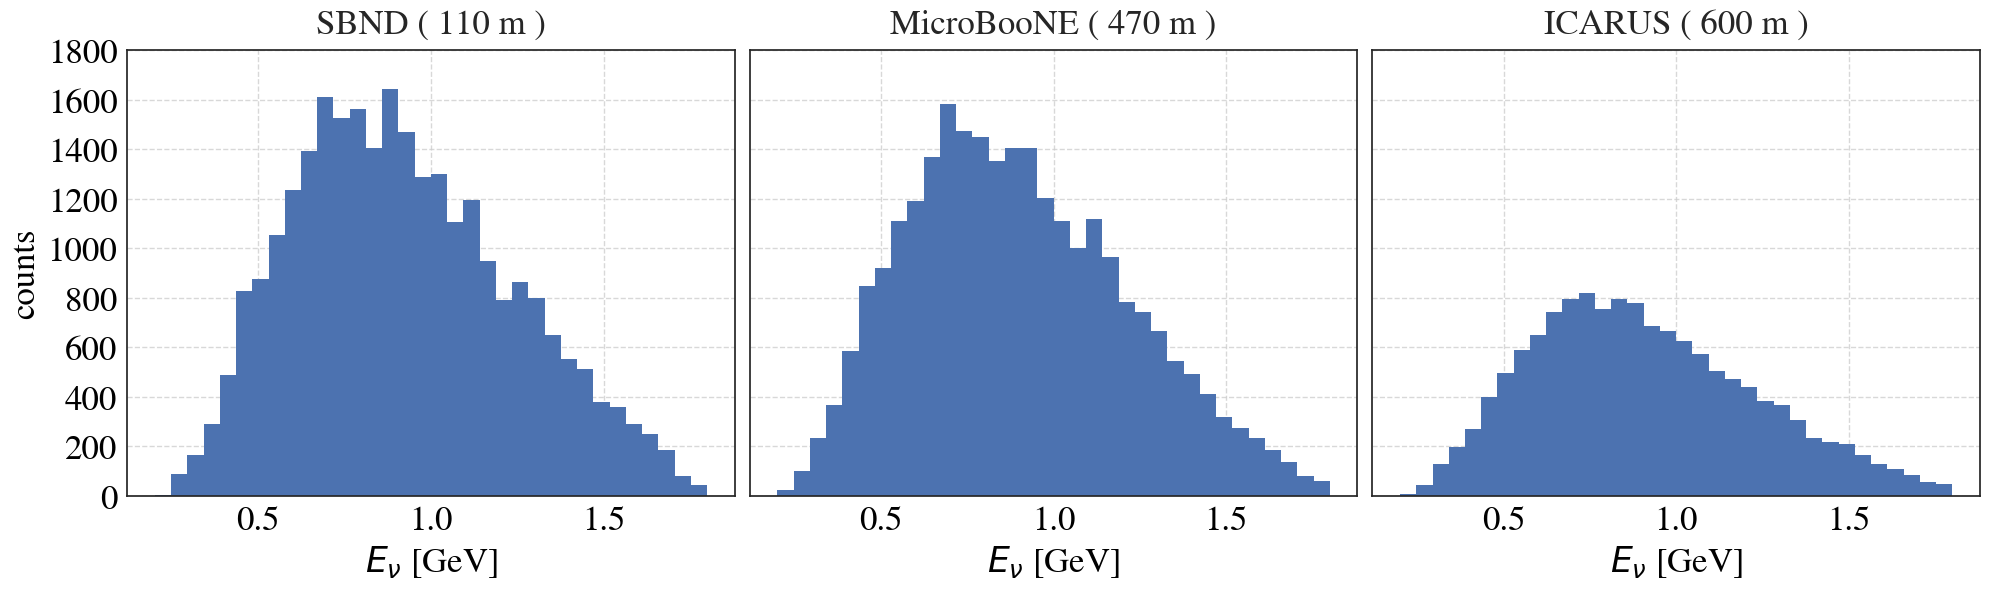

In [5]:
fig = plt.figure(figsize=(20,6))
bins = linspace(0.2,1.8,35)
for iax,(gname,glabel,L) in enumerate(zip(genie_SBN_list,genie_SBN_labels,genie_SBN_L)):
    ax = fig.add_subplot(1,3,iax+1)
    genie = afro_genie_CC1p_dict[gname]
    plt.hist( genie['truth_Ev'] , bins=bins)
    set_axes(ax,r'$E_\nu$ [GeV]',
             'counts' if iax==0 else '',
             xticks=[0.5,1.,1.5],
             ylim=(0,1800),
             remove_ticks_y=False if iax==0 else True,
             title=glabel+' ( %d'%L+' m )',
             do_add_grid=True)
plt.tight_layout()

# now add oscillations
from the SBN proposal
$$
P_{\nu_{\mu}\rightarrow\nu_{\mu}}^{3+1}= 1 - \sin^{2}2\theta_{\mu \mu}\sin^{2}\left(\frac{\Delta m^{2} L}{4 E_{\nu}}\right)
$$
and in SI:
$$
P_{\nu_{\mu}\rightarrow\nu_{\mu}}^{3+1}= 1 - \sin^{2}2\theta_{\mu \mu}\sin^{2}\left(1.27\left|\Delta m_{14}\left[eV\right]\right|^{2}\frac{L\left[m\right]}{E_{\nu}\left[MeV\right]}\right)
$$

In [6]:
def P_mu_mu(L=600 # m
            , Ev=0.7 # GeV
            , sin2_2theta=0.1 
            , Delta_m_2=0.4 # eV^2
           ):
    return 1 - sin2_2theta*np.square(np.sin( 1.27 * Delta_m_2 * L / (1000*Ev)))

In [7]:
Delta_m_2 = 0.4
sin2_2theta = 0.1

for iax,(gname,glabel,L) in enumerate(zip(genie_SBN_list,genie_SBN_labels,genie_SBN_L)):
    genie = afro_genie_CC1p_dict[gname]
    genie['P_mu_mu'] = P_mu_mu(L=L, Ev=genie['truth_Ev'] , sin2_2theta=sin2_2theta, Delta_m_2=Delta_m_2)

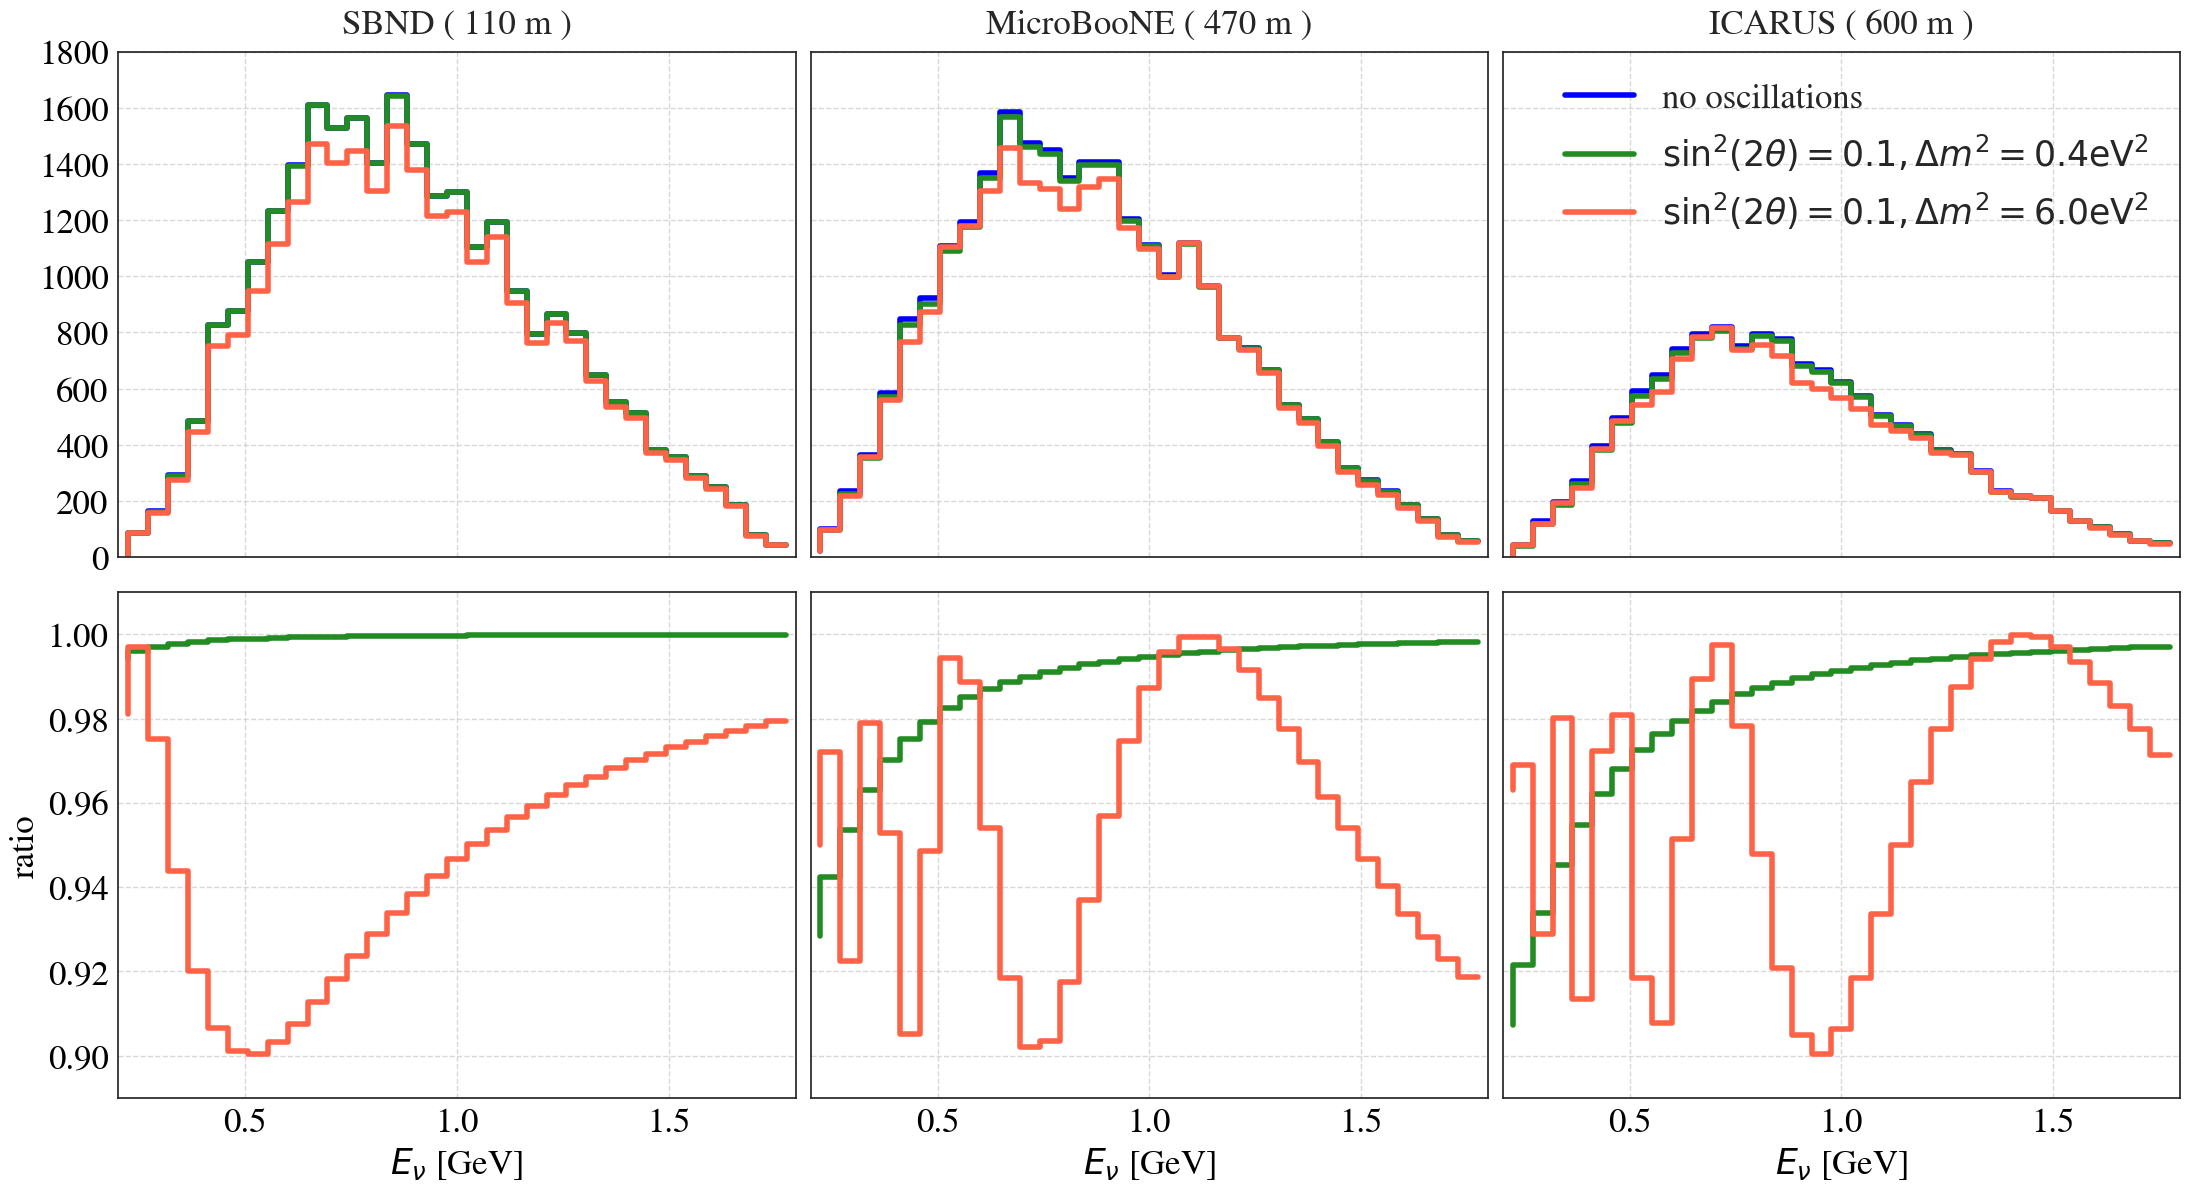

In [28]:
fig = plt.figure(figsize=(22,12))
bins = linspace(0.2,1.8,35); mid=0.5*(bins[1:]+bins[:-1]); bin_widht=mid[1]-mid[0]
for iax,(gname,glabel,L) in enumerate(zip(genie_SBN_list,genie_SBN_labels,genie_SBN_L)):
    h = dict()
    ax = fig.add_subplot(2,3,iax+1)
    genie = afro_genie_CC1p_dict[gname]
    h['no oscillations'],_ = np.histogram( genie['truth_Ev'] , bins=bins )
    plt.step(mid,h['no oscillations'],linewidth=4, label='no oscillations', color='blue')
#     plt.errorbar(x=mid,y=h['no oscillations'],yerr=np.sqrt(h['no oscillations']),linewidth=4, color='blue',fmt='.')


    for sin2_2theta,Delta_m_2,color in zip([0.1,0.1],[0.4,6.0],['forestgreen','tomato']):
        h[sin2_2theta+Delta_m_2],_ = np.histogram( genie['truth_Ev'] , bins=bins ,weights=P_mu_mu(L=L, Ev=genie['truth_Ev'] , sin2_2theta=sin2_2theta, Delta_m_2=Delta_m_2))                              
        plt.step(mid,h[sin2_2theta+Delta_m_2],linewidth=4, color=color, label=r'$\sin^2(2\theta)=%.1f, \Delta m^2=%.1f \mathrm{eV}^2$'%(sin2_2theta,Delta_m_2))
#         plt.errorbar(x=mid,y=h[sin2_2theta+Delta_m_2],yerr=np.sqrt(h[sin2_2theta+Delta_m_2]),linewidth=4, color=color,fmt='.')


    set_axes(ax,x_label='',y_label='',
             xticks=[0.5,1.,1.5],xlim=(0.2,1.8),
             ylim=(0,1800),
             do_add_legend=True if iax==2 else False,
             remove_ticks_y=False if iax==0 else True,
             remove_ticks_x=True,
             title=glabel+' ( %d'%L+' m )',
             do_add_grid=True)

    ax = fig.add_subplot(2,3,iax+4)
    for sin2_2theta,Delta_m_2,color in zip([0.1,0.1],[0.4,6.0],['forestgreen','tomato']):
        ratio = h[sin2_2theta+Delta_m_2]/h['no oscillations']
        plt.step(mid , ratio , linewidth=4,  color=color)

    set_axes(ax,x_label=r'$E_\nu$ [GeV]',y_label='ratio' if iax==0 else '',
             xticks=[0.5,1.,1.5],xlim=(0.2,1.8),
             ylim=(0.89,1.01),
             do_add_legend=True if iax==2 else False,
             remove_ticks_y=False if iax==0 else True,
             do_add_grid=True)
plt.tight_layout()

# Add $E_\nu$ smearing from the overlay

In [15]:
_,_,selected_CC1p,_,_,_ = load_mc_and_data()

found selected overlay files from , loading them...
9538 selected CC1p events overlay
found  462 selected on beam and 15 beam off events...
found selected genie CC1p...


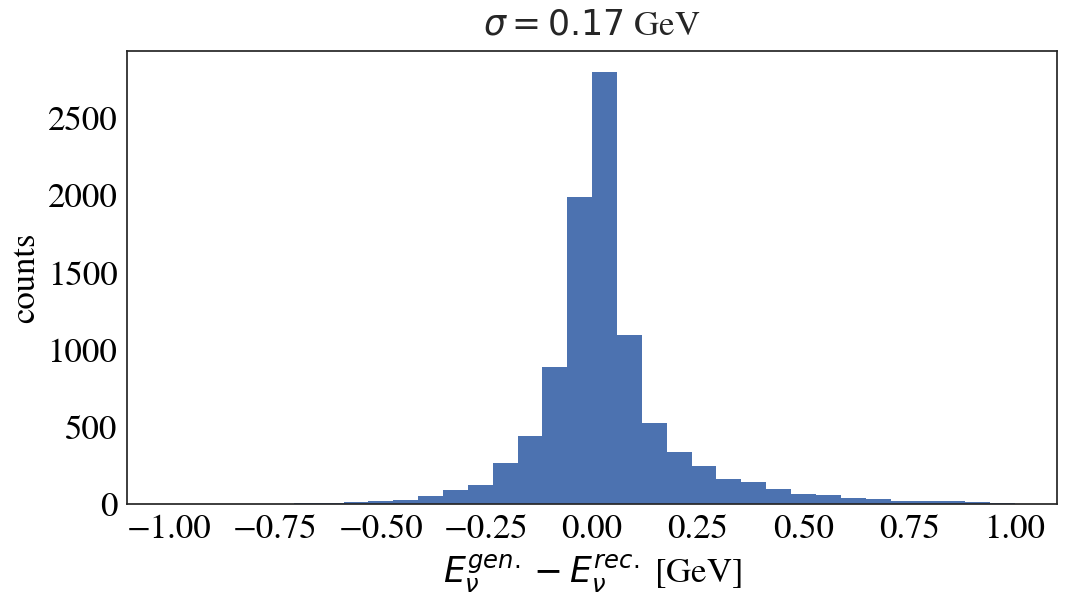

In [25]:
fig,ax=plt.subplots(figsize=(12,6))
gen,rec=selected_CC1p['closest_genie_Ev'],selected_CC1p['reco_Ev_mcs']
delta = gen-rec
mean=np.mean(delta)
std=np.std(delta[np.abs(delta)<1])
plt.hist(delta,bins=linspace(-1,1,35));
set_axes(ax,r'$E_\nu^{gen.}-E_\nu^{rec.}$ [GeV]','counts',title='$\sigma=%.2f$ GeV'%std)

In [27]:
sigma_Ev = 0.17

for iax,(gname,glabel,L) in enumerate(zip(genie_SBN_list,genie_SBN_labels,genie_SBN_L)):
    genie = afro_genie_CC1p_dict[gname]
    genie['smeared_Ev'] = np.random.normal(genie['truth_Ev'], sigma_Ev)

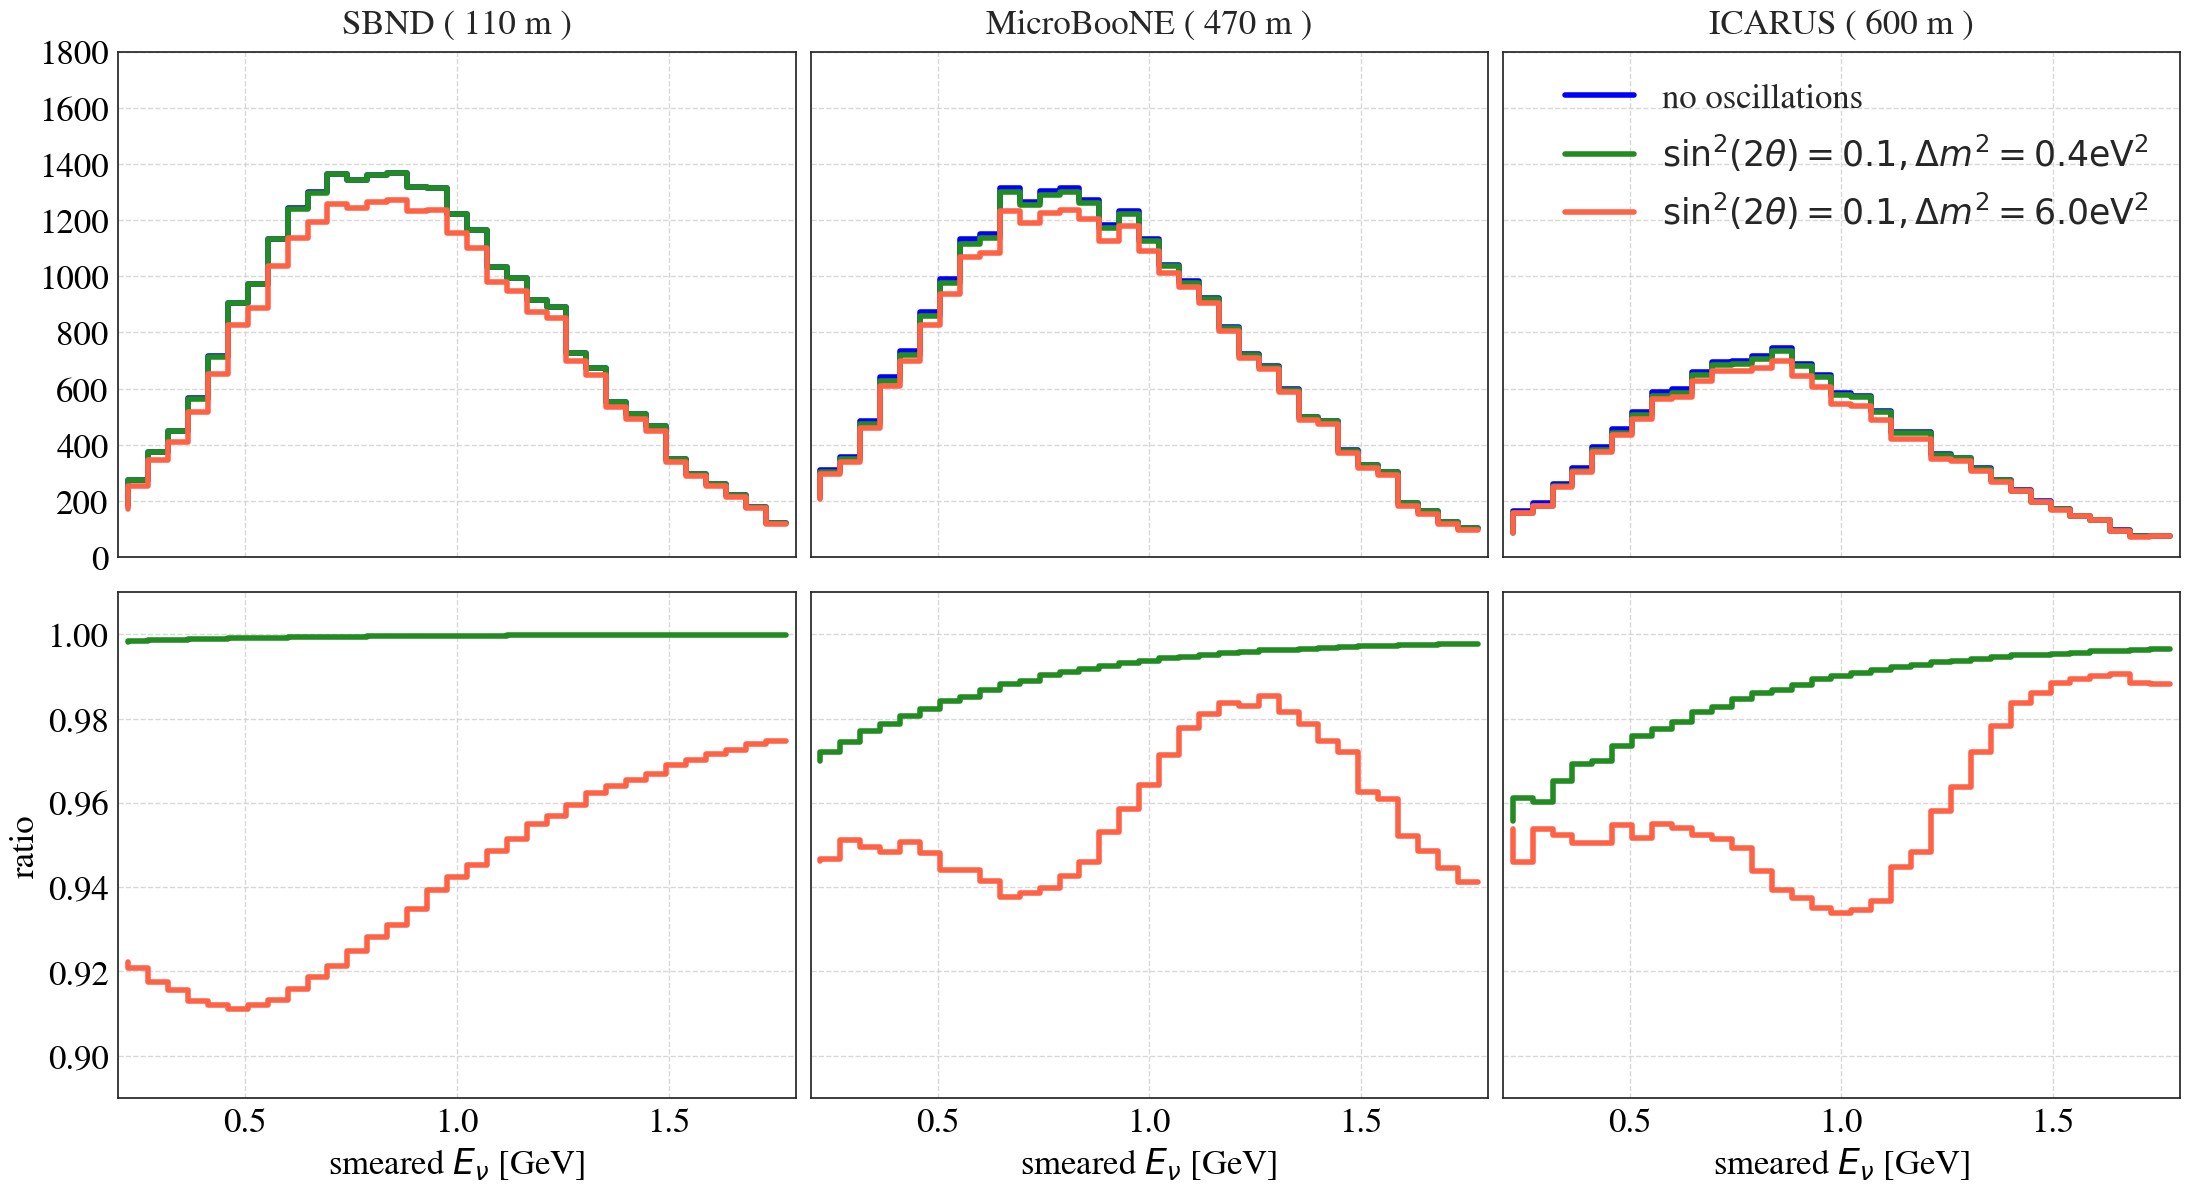

In [29]:
fig = plt.figure(figsize=(22,12))
bins = linspace(0.2,1.8,35); mid=0.5*(bins[1:]+bins[:-1]); bin_widht=mid[1]-mid[0]
for iax,(gname,glabel,L) in enumerate(zip(genie_SBN_list,genie_SBN_labels,genie_SBN_L)):
    h = dict()
    ax = fig.add_subplot(2,3,iax+1)
    genie = afro_genie_CC1p_dict[gname]
    h['no oscillations'],_ = np.histogram( genie['smeared_Ev'] , bins=bins )
    plt.step(mid,h['no oscillations'],linewidth=4, label='no oscillations', color='blue')
#     plt.errorbar(x=mid,y=h['no oscillations'],yerr=np.sqrt(h['no oscillations']),linewidth=4, color='blue',fmt='.')


    for sin2_2theta,Delta_m_2,color in zip([0.1,0.1],[0.4,6.0],['forestgreen','tomato']):
        h[sin2_2theta+Delta_m_2],_ = np.histogram( genie['smeared_Ev'] , bins=bins ,weights=P_mu_mu(L=L, Ev=genie['truth_Ev'] , sin2_2theta=sin2_2theta, Delta_m_2=Delta_m_2))                              
        plt.step(mid,h[sin2_2theta+Delta_m_2],linewidth=4, color=color, label=r'$\sin^2(2\theta)=%.1f, \Delta m^2=%.1f \mathrm{eV}^2$'%(sin2_2theta,Delta_m_2))
#         plt.errorbar(x=mid,y=h[sin2_2theta+Delta_m_2],yerr=np.sqrt(h[sin2_2theta+Delta_m_2]),linewidth=4, color=color,fmt='.')


    set_axes(ax,x_label='',y_label='',
             xticks=[0.5,1.,1.5],xlim=(0.2,1.8),
             ylim=(0,1800),
             do_add_legend=True if iax==2 else False,
             remove_ticks_y=False if iax==0 else True,
             remove_ticks_x=True,
             title=glabel+' ( %d'%L+' m )',
             do_add_grid=True)

    ax = fig.add_subplot(2,3,iax+4)
    for sin2_2theta,Delta_m_2,color in zip([0.1,0.1],[0.4,6.0],['forestgreen','tomato']):
        ratio = h[sin2_2theta+Delta_m_2]/h['no oscillations']
        plt.step(mid , ratio , linewidth=4,  color=color)

    set_axes(ax,x_label=r'smeared $E_\nu$ [GeV]',y_label='ratio' if iax==0 else '',
             xticks=[0.5,1.,1.5],xlim=(0.2,1.8),
             ylim=(0.89,1.01),
             do_add_legend=True if iax==2 else False,
             remove_ticks_y=False if iax==0 else True,
             do_add_grid=True)
plt.tight_layout()

# verify that we know how to do oscillations

In [9]:
L_detectors = dict({'SBND':110,'MicroBooNE':470,'ICARUS':600})
E_BNB_peak = 0.7
E_array = linspace( 0.2, 3, 200 )
L_array = linspace( 0, 900, 200 )

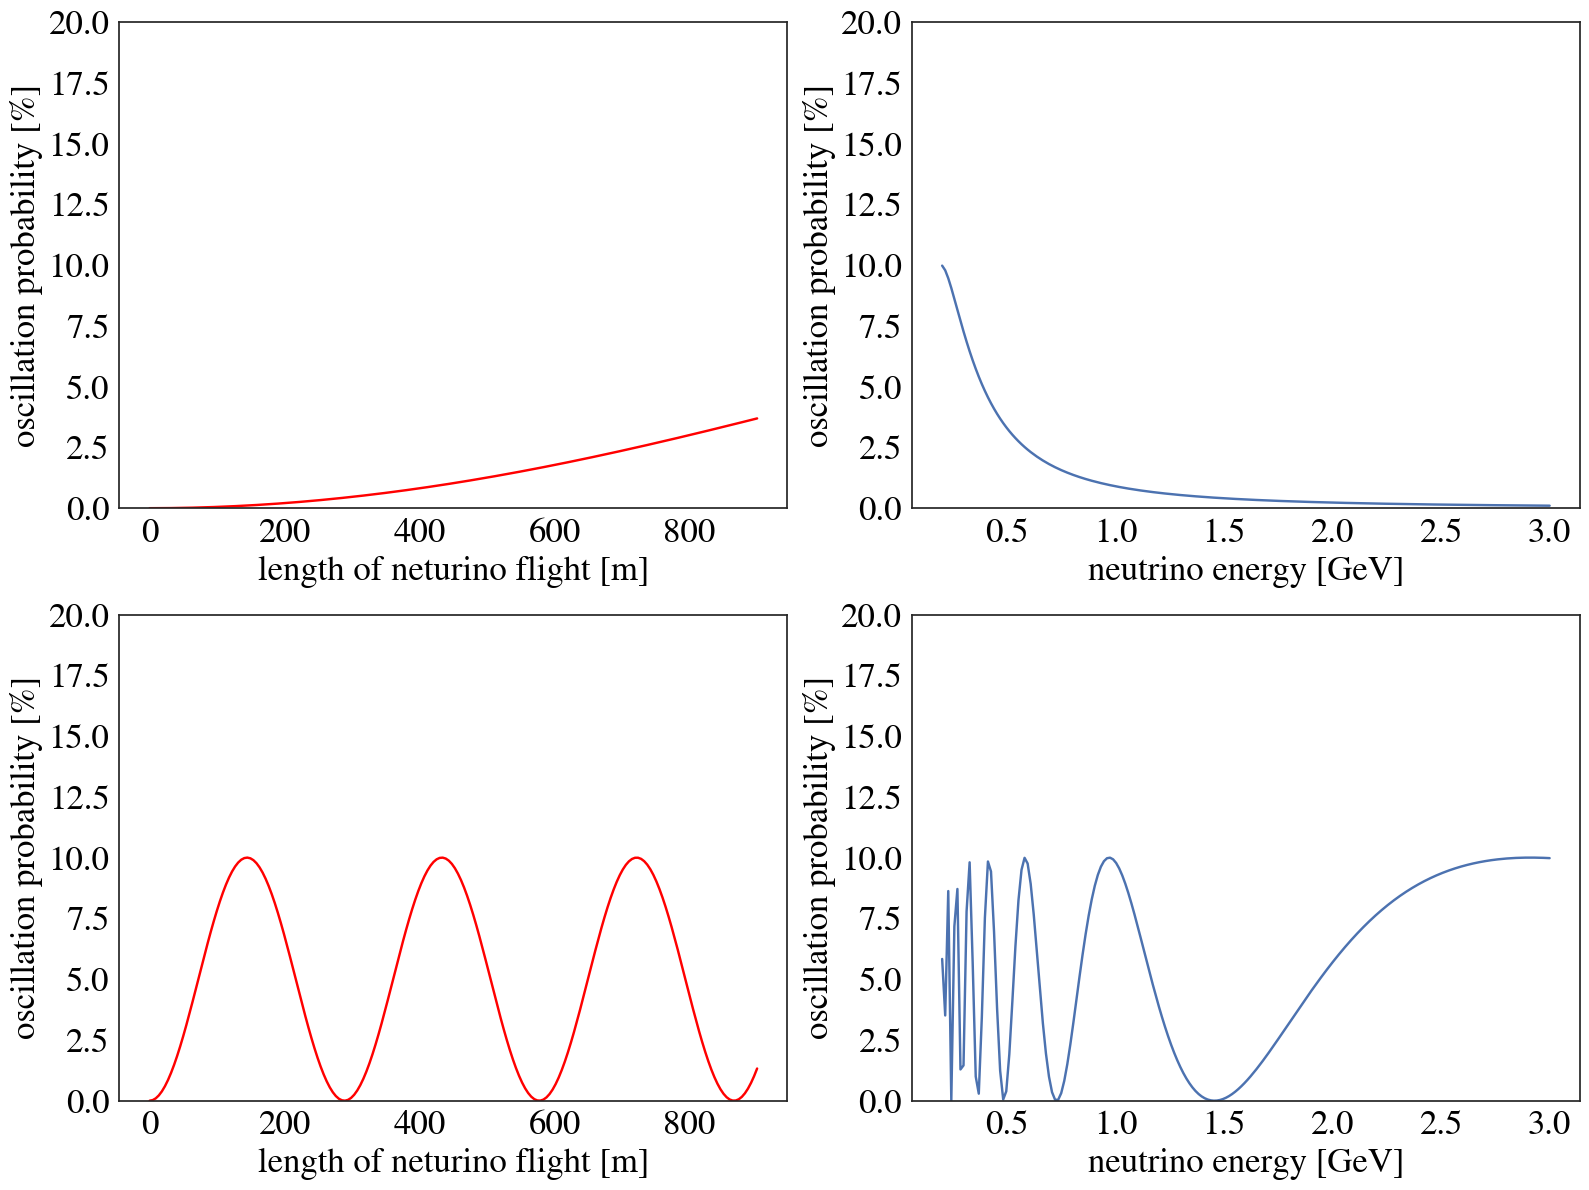

In [10]:
sin2_2theta=0.1 

fig = plt.figure(figsize=(16,12))

Delta_m_2=0.4

ax = fig.add_subplot(2,2,1)
P_oscillation = 1 - P_mu_mu(L=L_array,Ev=E_BNB_peak,sin2_2theta=sin2_2theta,Delta_m_2=Delta_m_2)
plt.plot(L_array,100*P_oscillation,color='red')
set_axes(ax,r'length of neturino flight [m]',r'oscillation probability [%]',ylim=(0,20))


ax = fig.add_subplot(2,2,2)
P_oscillation = 1 - P_mu_mu(L=L_detectors['ICARUS'],Ev=E_array,sin2_2theta=sin2_2theta,Delta_m_2=Delta_m_2)
plt.plot(E_array,100*P_oscillation)
set_axes(ax,r'neutrino energy [GeV]',r'oscillation probability [%]',ylim=(0,20))


Delta_m_2=6.0

ax = fig.add_subplot(2,2,3)
P_oscillation = 1 - P_mu_mu(L=L_array,Ev=E_BNB_peak,sin2_2theta=sin2_2theta,Delta_m_2=Delta_m_2)
plt.plot(L_array,100*P_oscillation,color='red')
set_axes(ax,r'length of neturino flight [m]',r'oscillation probability [%]',ylim=(0,20))


ax = fig.add_subplot(2,2,4)
P_oscillation = 1 - P_mu_mu(L=L_detectors['ICARUS'],Ev=E_array,sin2_2theta=sin2_2theta,Delta_m_2=Delta_m_2)
plt.plot(E_array,100*P_oscillation)
set_axes(ax,r'neutrino energy [GeV]',r'oscillation probability [%]',ylim=(0,20))

plt.tight_layout()

# cross-section as a function of $E_\nu$